## Imports and Configurations

### Importing Libraries

Essential libraries for data processing, visualization, and geospatial analysis are imported in this cell.

In [1]:
import ast
import csv
import geojson
import geopandas as gpd
import json
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
import re
import requests
import seaborn as sns
import statistics
import sys
import numpy as np

from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from bson.json_util import dumps
from colorama import Fore, Style, init
from datetime import datetime, time, timedelta
from geopy.distance import geodesic
from matplotlib import ticker
from pathlib import Path
from pymongo import MongoClient, errors
from scipy.spatial import ConvexHull
from shapely.geometry import Point
from typing import *
from typing import Dict
from scipy.stats import gaussian_kde

### Matplotlib Backend Configuration

This line sets the plotting backend for Matplotlib to enable interactive plots. **Warning:** This notebook generates up to **24** plots

In [2]:
#  %matplotlib tk

## Define core configuration parameters

This section defines essential constants and configuration flags used throughout the analysis:
- Includes paths
- Configures database settings
- Sets geographic boundaries for Tripoli
- Constructs a utuility function `filter_within_bbox` to filter data for Tripoli's_BBOX
- Sets plt constants for better LaTex visualization
- Handles API configuration:
  - Reads the `dict_api_CONFIG.py` file
  - Adds the current timestamp to the `snapshot_api.endDate` field
  - Writes the updated configuration back to file
  - Readies the `snapshot API` with current datetime (datetime.now()) values


In [3]:
# ----Flags----
UPDATE_DB               = False

#----Constants---
PLOT_FOLDER_PATH        =   "./Plots/All_data_analysis/"
SUB_PLOTS_FOLDER_PATH   =   "./Plots/All_data_analysis/Sub_Plots/"
NOISE_VELOCITIES        =   60

GEOJSON_FOLDER_PATH     =   "../../DataSets/GeoJSON/"
DB_URI                  =   "mongodb://localhost:27017/"
DB_NAME                 =   "Ptyxiaki"
DB_COLLECION            =   "Unique_Vehicles_GeoJSON"
TRIPOLI_BBOX            = {
                            'latMin': 37.49764419371479,
                            'latMax': 37.56244081620044,
                            'lngMin': 22.344992459074458,
                            'lngMax': 22.521463853839485
}

def filter_within_bbox(df, bbox):
    """Remove rows from DataFrame not within the specified bounding box and print count of deleted rows."""
    original_count = len(df)
    filtered_df = df[
        (df['lat'] >= bbox['latMin']) & (df['lat'] <= bbox['latMax']) &
        (df['lng'] >= bbox['lngMin']) & (df['lng'] <= bbox['lngMax'])
    ].reset_index(drop=True)
    deleted_count = original_count - len(filtered_df)
    print(f"Deleted {deleted_count} rows not within the bounding box.")
    return filtered_df


# *Update PARAMETERS file with current datetime
PARAMETERS_F_PATH = "dict_api_CONFIG.py" 

# Get the current date and time
current_datetime    = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time        = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(PARAMETERS_F_PATH):
    print(f"Error: The file '{PARAMETERS_F_PATH}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(PARAMETERS_F_PATH) == 0:
    print(f"Error: The file '{PARAMETERS_F_PATH}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(PARAMETERS_F_PATH, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(PARAMETERS_F_PATH, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2025-07-11 00:45:10.


### Save Output to CSV (Utility Function)

Utility function that saves a non-empty DataFrame to CSV. If the DataFrame is empty, it logs a message and skips saving.


In [4]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        PARAMETERS_F_PATH = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(PARAMETERS_F_PATH, index=False)  # Overwrite the CSV file by default
        print(f"Data saved to {PARAMETERS_F_PATH}")
    else:
        print(f"No data to save for {file_name}. Skipping...")
        



### Create a class for managing Snapshot and Live APIs
 
#### ApiParameterExtractor Class

A class to extract API parameters from a JSON file based on the API type.

#### Description

`ApiParameterExtractor` reads a JSON file containing API parameters and allows you to extract parameters for a specified API type, such as `'live_api'` or `'snapshot_api'`.

#### Initialization

In [5]:
class ApiParameterExtractor:
    """
    Class to extract API parameters from a given JSON file based on API type.

    :param json_file: Path to the JSON file containing the parameters.
    """
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        """
        Extract parameters for a specified API type ('live_api' or 'snapshot_api').

        :param api_type: The type of API to extract parameters for.
        :return: Dictionary containing parameters for the given API type.
        """
        api_type = api_type.lower()

        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")

        return self.parameters[api_type]

# Assuming PARAMETERS_F_PATH is the path to your JSON file
extractor               = ApiParameterExtractor(PARAMETERS_F_PATH)

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Initialize ApiManager instances with extracted parameters
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)


# Visualize data **dispersion**

## Fetch Snapshot API

### Utility finction to convert `UNIX Timestamp` to `datetime` using `Pandas`

In [6]:
# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")




### Utility function to merge all DataFrames (each `DataFrame` contains data for each unique `Vehicle ID`)

In [7]:
def merge_vehicles_df(ALL_vehicles_dfS):
    """
    Merge multiple DataFrames into one single DataFrame.

    :param ALL_vehicles_dfS: List of DataFrames to merge.
    :return: A single merged DataFrame containing all rows from the input DataFrames.
    """
    result = pd.concat(ALL_vehicles_dfS, ignore_index=True)
    print(type(result))
    return result

# It has been noticed that after a random time some vehicle IDs where **deleted** from the database. luckily, I have storred them and I will add them to the target DF

In [8]:
# === Function to fetch backup vehicle data ===
def fetch_formerly_vehicle_data(formerly_vehicleID):
    file_path = f"../../DataSets/API_Responses/Vehicle_Data/Vehicle_{formerly_vehicleID}_response.csv"
    with open(file_path, "r") as vID:
        return pd.read_csv(vID)


## Execute Snapshot API call

In [9]:
# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
# snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv" 

# === Step 1: Load Parameters from JSON File ===
with open(PARAMETERS_F_PATH, "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the Dictionary

# === Step 2: Loop to Fetch and Append Data for Each Vehicle ===
vehicleID = 1  # Counter for vehicle IDs
ALL_vehicles_dfS = []

while vehicleID <= 20:  # 20 Vehicles (filtered only for Tripoli's BBOX)
    PARAMETERS["snapshot_api"]["vehicleId"] = str(vehicleID)
    
    # !Fetch snapshot data (Returns JSON or None or -42 in case no Data was found in DataBse)
    snapshot_data = snapshot_api_manager.get_snapshot_data(
        str(vehicleID),
        PARAMETERS["snapshot_api"]["startDate"],
        PARAMETERS["snapshot_api"]["endDate"]
    )
    
    if snapshot_data == -42: 
        # !No data in DataBase for current VehicleID, fetch from foremrly data
        print(f"No data found in DataBase for vehicleID = {vehicleID}. Importing from formerly saved data...")
        ALL_vehicles_dfS.append(fetch_formerly_vehicle_data(vehicleID))
    
    # Fallback to CSV if no data returned
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleID}.")
        vehicleID += 1
        continue

    # Parse JSON response
    try:
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict
        else:
            snapshot_data_list = []

        snapshot_vehicles_df = pd.DataFrame(snapshot_data_list)
        ALL_vehicles_dfS.append(snapshot_vehicles_df)

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for vehicleId {vehicleID}: {e}")

    vehicleID += 1

# === Final Merge and Save ===
vehicles_df = merge_vehicles_df(ALL_vehicles_dfS)
print(type(vehicles_df))

if not vehicles_df.empty:
    save_to_csv(vehicles_df, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")


Snapshot API:: VehicleId: 1 Request Successful!
Snapshot API:: VehicleId: 2 returned 0 records.
No data found in DataBase for vehicleID = 2. Importing from formerly saved data...
Snapshot API:: VehicleId: 3 returned 0 records.
No data found in DataBase for vehicleID = 3. Importing from formerly saved data...
Snapshot API:: VehicleId: 4 Request Successful!
Snapshot API:: VehicleId: 5 Request Successful!
Snapshot API:: VehicleId: 6 returned 0 records.
No data found in DataBase for vehicleID = 6. Importing from formerly saved data...
Snapshot API:: VehicleId: 7 Request Successful!
Snapshot API:: VehicleId: 8 Request Successful!
Snapshot API:: VehicleId: 9 Request Successful!
Snapshot API:: VehicleId: 10 returned 0 records.
No data found in DataBase for vehicleID = 10. Importing from formerly saved data...
Snapshot API:: VehicleId: 11 Request Successful!
Snapshot API:: VehicleId: 12 Request Successful!
Snapshot API:: VehicleId: 13 Request Successful!
Snapshot API:: VehicleId: 14 Request Su

### Plot number of data lines for each vehicle

Vehicle ID 1: 2834 rows
Vehicle ID 2: 56 rows
Vehicle ID 3: 79 rows
Vehicle ID 4: 8 rows
Vehicle ID 5: 6742 rows
Vehicle ID 6: 93 rows
Vehicle ID 7: 19505 rows
Vehicle ID 8: 814 rows
Vehicle ID 9: 12714 rows
Vehicle ID 10: 23 rows
Vehicle ID 11: 15 rows
Vehicle ID 12: 18 rows
Vehicle ID 13: 211 rows
Vehicle ID 14: 2193 rows
Vehicle ID 15: 33878 rows
Vehicle ID 16: 40 rows
Vehicle ID 17: 129 rows
Vehicle ID 18: 89 rows
Vehicle ID 19: 52 rows
Vehicle ID 20: 885 rows


/tmp/ipykernel_6465/3857766756.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))


Plot saved to ./Plots/All_data_analysis/vehicle_rows_per_id.png


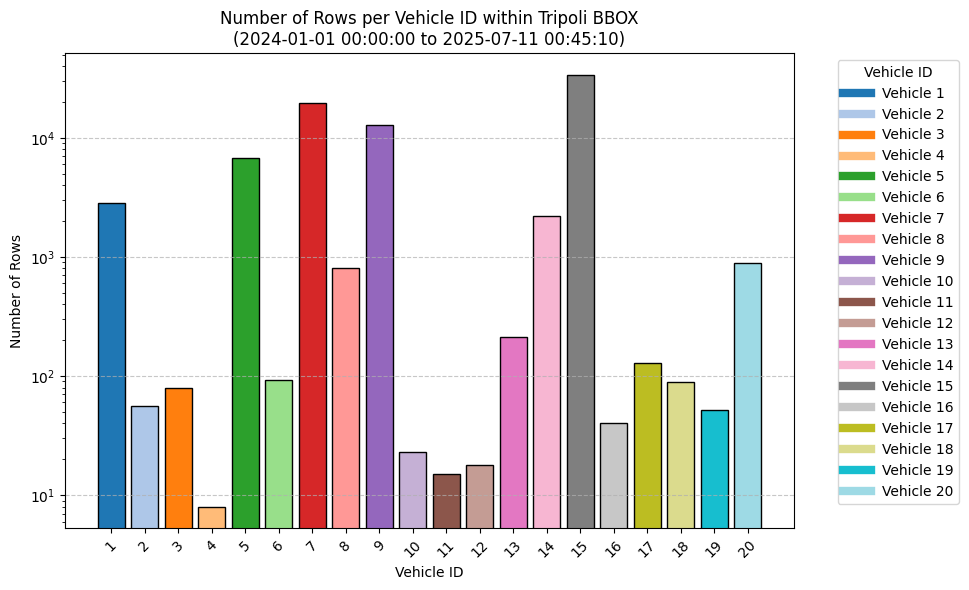

In [10]:
# === Step 4: Collect Unique Vehicle IDs and Rows Count from Filtered Data ===
expected_vehicle_ids = list(range(1, 21))  # Vehicle IDs from 1 to 20

if vehicles_df.empty:
    print("No data within bounding box to process!")
else:
    # Ensure 'vehicleId' is an integer
    vehicles_df['vehicleId'] = vehicles_df['vehicleId'].astype(int)

    # Initialize row counts with 0 for all expected vehicles
    vehicle_rows_dict       = {veh_id: 0 for veh_id in expected_vehicle_ids}

    # Count rows for each vehicle ID present in the filtered data
    actual_counts           = vehicles_df['vehicleId'].value_counts().to_dict()

    # Update the dictionary with actual counts
    for veh_id, count in actual_counts.items():
        vehicle_rows_dict[int(veh_id)] = count

    # Prepare data for plotting
    unique_veh_ids = list(vehicle_rows_dict.keys())
    vehicle_rows   = list(vehicle_rows_dict.values())

    # Debug: Print counts
    for vehicle_id, rows in zip(unique_veh_ids, vehicle_rows):
        print(f"Vehicle ID {vehicle_id}: {rows} rows")

    # Generate a colormap
    num_vehicles = len(unique_veh_ids)
    colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_veh_ids, vehicle_rows, color=colors, edgecolor='black')

    # Add legend (optional for 20 vehicles)
    legend_handles = [plt.Line2D([0], [0], color=color, lw=6, label=f'Vehicle {vehicle_id}')
                      for color, vehicle_id in zip(colors, unique_veh_ids)]
    plt.legend(handles=legend_handles, title="Vehicle ID", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Vehicle ID')
    plt.ylabel('Number of Rows')
    plt.title(f'Number of Rows per Vehicle ID within Tripoli BBOX\n({PARAMETERS["snapshot_api"]["startDate"]} to {PARAMETERS["snapshot_api"]["endDate"]})')
    plt.xticks(unique_veh_ids, rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yscale("log")

    plot_save_path = os.path.join(PLOT_FOLDER_PATH, "vehicle_rows_per_id.png")
    plt.savefig(plot_save_path, bbox_inches='tight')
    print(f"Plot saved to {plot_save_path}")
    plt.show()


## Filter data inside of Tripoli's BBOX

In [11]:
vehicles_df = filter_within_bbox(vehicles_df, TRIPOLI_BBOX)

Deleted 33339 rows not within the bounding box.


#### Plot percentage of **noise velocities**

In [12]:
in_bbox = vehicles_df[
    (vehicles_df['lat'] >= TRIPOLI_BBOX['latMin']) & (vehicles_df['lat'] <= TRIPOLI_BBOX['latMax']) &
    (vehicles_df['lng'] >= TRIPOLI_BBOX['lngMin']) & (vehicles_df['lng'] <= TRIPOLI_BBOX['lngMax'])
]

# Calculate the percentage of rows inside the bounding box
percentage_in_bbox = (len(in_bbox) / len(vehicles_df)) * 100

# Set color based on whether all rows are inside the bounding box
color = Fore.GREEN if percentage_in_bbox == 100 else Fore.YELLOW


print(color + f"Percentage of rows inside the bounding box: {percentage_in_bbox:.2f}%" + Style.RESET_ALL)


Percentage of rows inside the bounding box: 100.00%


## Break the datetime to 3 readable formats:
1. Datetime Stored
2. Date Stored Only
3. Time Stored Only



### Then: **sort by datetime Stored** (ascending)

In [13]:
# Convert the 'dateStored' column to datetime format
vehicles_df['dateStoredHuman']           = vehicles_df['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
vehicles_df['dateOnlyStoredHuman']       = vehicles_df['dateStoredHuman'].dt.date  # Extract the date only
vehicles_df['timeOnly']                  = vehicles_df['dateStoredHuman'].dt.time  # Extract the time only

#! Sort the DataFrame by 'dateStored' in ascending order
vehicles_df                              = vehicles_df.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                                = vehicles_df['lat']
long_clmn                               = vehicles_df['lng']
date_stored                             = vehicles_df['dateStored']

# #! Drop temp columns
# vehicles_df = vehicles_df.drop(columns=['dateStoredHuman'])



print(vehicles_df.head())

   vehicleId        lat        lng     dateStored  velocity  odometer  \
0          1  37.510833  22.385710  1717682537000       0.0       0.0   
1          1  37.510603  22.385977  1717682540000       0.0       0.0   
2          1  37.510640  22.385927  1717682545000       6.0       0.0   
3          1  37.510750  22.385907  1717682551000       7.0       0.0   
4          1  37.510877  22.385698  1717682557000      26.0       0.0   

   engineVoltage     dateStoredHuman dateOnlyStoredHuman  timeOnly  
0           0.28 2024-06-06 17:02:17          2024-06-06  17:02:17  
1           0.28 2024-06-06 17:02:20          2024-06-06  17:02:20  
2           0.28 2024-06-06 17:02:25          2024-06-06  17:02:25  
3           0.28 2024-06-06 17:02:31          2024-06-06  17:02:31  
4           0.28 2024-06-06 17:02:37          2024-06-06  17:02:37  


## Create **"Trips"**:
- "Trip" is defined as the difference >= 5 between the current and last date-time for a vehicle

In [14]:
# Ensure 'dateStoredHuman' is in datetime format
vehicles_df['dateStoredHuman'] = pd.to_datetime(vehicles_df['dateStoredHuman'])

# Sort data by vehicleId and dateStoredHuman
vehicles_df = vehicles_df.sort_values(by=['vehicleId', 'dateStoredHuman'])

# Compute time differences between consecutive rows within each vehicle in minutes
vehicles_df['seconds_diff'] = vehicles_df['dateStoredHuman'].diff().dt.total_seconds()    #.div(60)

# Print seconds_diff for debugging
print(vehicles_df[['vehicleId', 'dateStoredHuman', 'seconds_diff']])


       vehicleId     dateStoredHuman  seconds_diff
0              1 2024-06-06 17:02:17           NaN
1              1 2024-06-06 17:02:20           3.0
2              1 2024-06-06 17:02:25           5.0
3              1 2024-06-06 17:02:31           6.0
4              1 2024-06-06 17:02:37           6.0
...          ...                 ...           ...
47034         20 2025-05-08 12:02:00           2.0
47035         20 2025-05-08 12:02:02           2.0
47036         20 2025-05-08 12:02:04           2.0
47037         20 2025-05-08 12:02:05           1.0
47038         20 2025-05-08 12:02:08           3.0

[47039 rows x 3 columns]


### Initialize `trip_id`(s) for each `vehicleId` 
- `trip_id` is defined as the *3 minutes time difference between current and previous timeStored*
    - `trip_id` reset per vehicle 
    - First `trip_id` is always NaN

In [15]:

# Define a new trip whenever the gap is 3 minutes or more, ensuring trip IDs reset per vehicle
vehicles_df['trip_id'] = (
    vehicles_df['seconds_diff'] >= 180  # gap of 3 min or more
).groupby(vehicles_df['vehicleId']).cumsum().fillna(0).astype(int)

# Fill NaN trip IDs (first row of each vehicle) with 0
vehicles_df['trip_id'] = vehicles_df['trip_id'].fillna(0).astype(int)

vehicles_df.loc[(vehicles_df['vehicleId'].diff() != 0) | (vehicles_df['trip_id'].diff() != 0), 'seconds_diff'] = 0.0

# Print an example
print(vehicles_df['trip_id'].head(10))


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: trip_id, dtype: int64


## Distances in meters (EST. ~1m 4s)

### Calculating Geodesic Distance Between GPS Points

This cell computes the **real-world distance** in meters between consecutive GPS coordinates and appends the result to the DataFrame.

#### Steps:

1. **Initialize distance list**  
   Start with a list called `distances` containing a `None` for the first row (since there’s no previous point to compare).

2. **Iterate through the DataFrame**  
   Loop over each row starting from the second one:
   - Extract the current and previous GPS coordinates (`lat`, `lng`).
   - Use `geopy.distance.geodesic()` to calculate the **geodesic distance** between the two points.
   - Round the result to 2 decimal places and append it to the list.

3. **Add distance column**  
   Add a new column `distance_m` to the `vehicles_df` DataFrame to store the computed distances.

4. **Reset distance at trip or vehicle change**  
   Set `distance_m` to `0.0` for rows where:
   - A new vehicle starts (`vehicleId` changes), or
   - A new trip begins (`trip_id` changes),  
   indicating that there is no meaningful prior point in the same trip context.

#### Notes:

- `geodesic()` accounts for the Earth's curvature (using the WGS-84 ellipsoid model), providing accurate real-world distances.
- This method avoids errors that would arise from treating the Earth as flat or using less precise distance formulas.


In [ ]:
distances = [None]  # First point has no previous point


for i in range(1, len(vehicles_df)):
    point1 = (vehicles_df.iloc[i-1]['lat'], vehicles_df.iloc[i-1]['lng'])
    point2 = (vehicles_df.iloc[i]['lat'], vehicles_df.iloc[i]['lng'])
    distance = round(geodesic(point1, point2).meters, 2)
    distances.append(distance)

# Add the distances as a new column
vehicles_df['distance_m'] = distances

vehicles_df.loc[(vehicles_df['vehicleId'].diff() != 0) | (vehicles_df['trip_id'].diff() != 0), 'distance_m'] = 0.0

## Plot **STD Variance** for all distance in meters

### This cell calculates and visualizes the standard deviation of GPS point-to-point distances (`distance_m`) for each trip, grouped by `vehicleId` and `trip_id`, to analyze driving variability:
1. Groups the data by `vehicleId` and `trip_id`, then calculates the standard deviation of `distance_m`.
2. Renames the resulting column to `std_trip` for clarity.
3. Splits the vehicles into two groups:
    - `vehicles_group1`: First half of the unique vehicles.
    - `vehicles_group2`: Second half.
4. Creates two subplots (side-by-side) for better visual separation:
    - Each line represents one vehicle, showing how the standard deviation changes per trip.
5. Adds gridlines, legends, labels, and an overall title for clarity.
6. Saves the final plot to a predefined path (`PLOT_FOLDER_PATH`).

In [ ]:
# Calculate standard deviation per trip and vehicle
std_per_trip = vehicles_df.groupby(['vehicleId', 'trip_id'])['distance_m'].std().reset_index()
std_per_trip.rename(columns={'distance_m': 'std_trip'}, inplace=True)

# Get all unique vehicles
all_vehicles = std_per_trip['vehicleId'].unique()
mid_point = len(all_vehicles) // 2
vehicles_group1 = all_vehicles[:mid_point]
vehicles_group2 = all_vehicles[mid_point:]

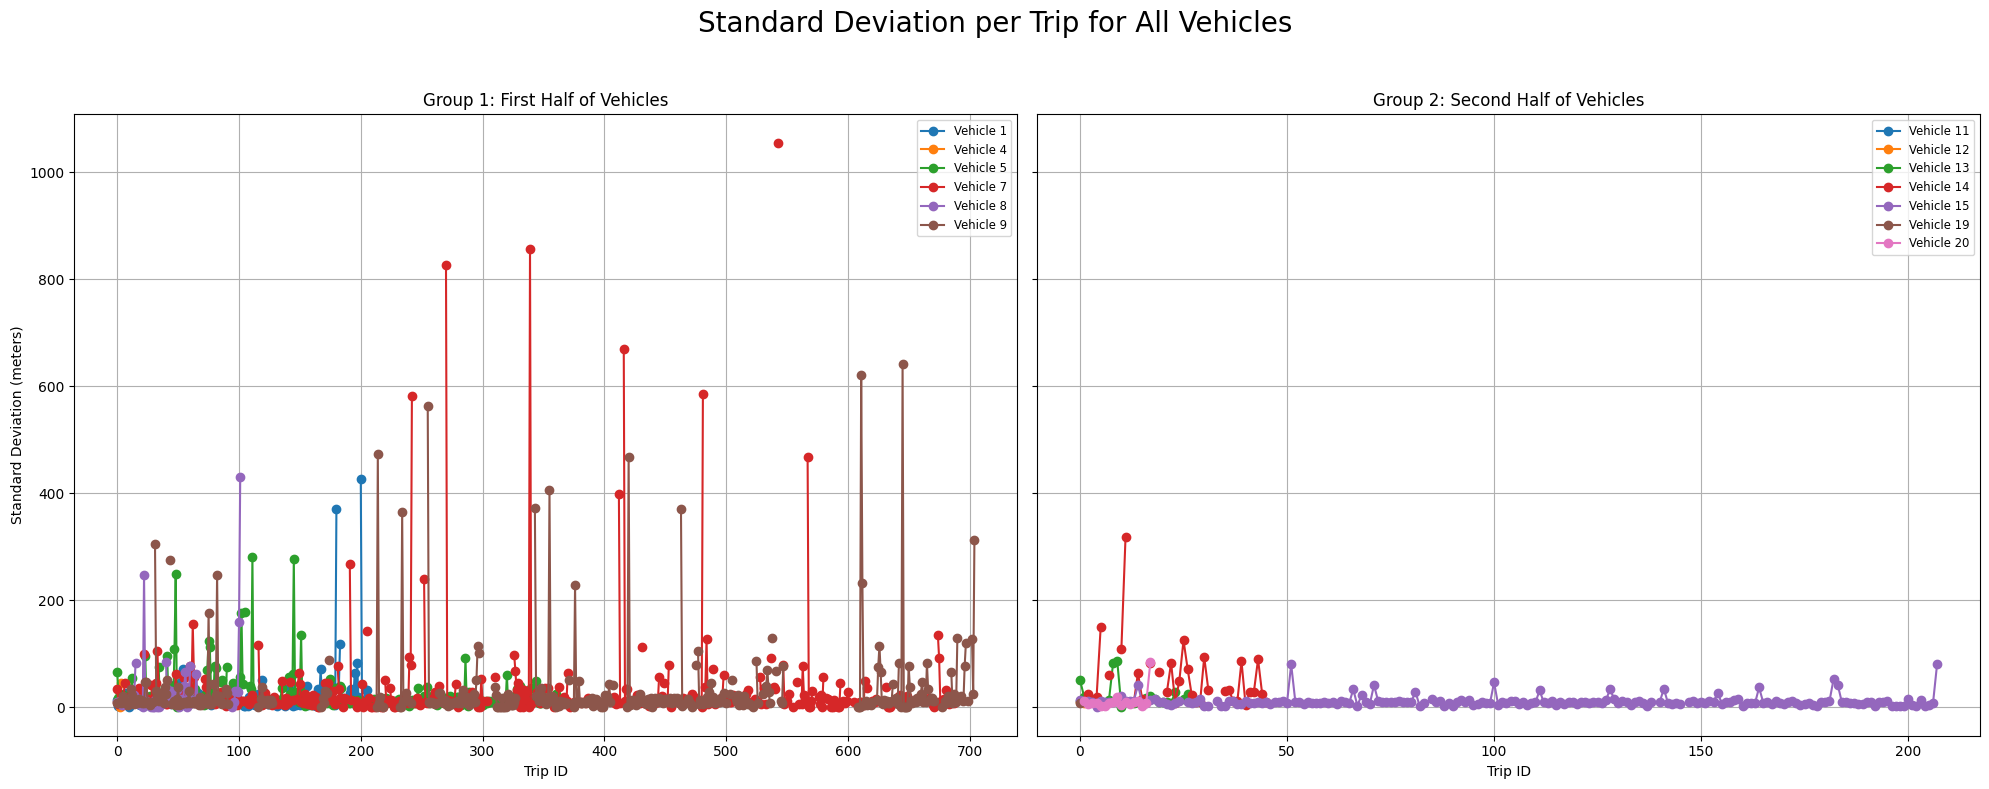

In [ ]:
# Set up 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)


# Plot for first group
for vehicle in vehicles_group1:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[0].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[0].set_title('Group 1: First Half of Vehicles')
axes[0].set_xlabel('Trip ID')
axes[0].set_ylabel('Standard Deviation (meters)')
axes[0].legend(fontsize="small")
axes[0].grid(True)

# Plot for second group
for vehicle in vehicles_group2:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[1].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[1].set_title('Group 2: Second Half of Vehicles')
axes[1].set_xlabel('Trip ID')
axes[1].legend(fontsize="small")
axes[1].grid(True)

# Overall title
plt.suptitle('Standard Deviation per Trip for All Vehicles', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviation_per_Trip_For_All_Vehicles.png")
plt.show()


## Find the mean distance in all data

Filters the dataset to exclude rows where the distance between consecutive GPS points is zero (`distance_m == 0.0`),
then computes and prints the mean distance traveled between valid points:

1. Filters `vehicles_df` to remove rows with `distance_m` equal to 0.0 (e.g., new trips or vehicles).
2. Calculates the mean of the remaining `distance_m` values.
3. Prints the computed mean distance to summarize average movement between valid GPS points.

In [ ]:
# Filter out rows where distance_m is 0.0
filtered_dfs = vehicles_df[vehicles_df['distance_m'] != 0.0]

# Find the mean distance across all data
mean_distance_nonzero = filtered_dfs['distance_m'].mean()

# Print the result
print(f"The mean distance (excluding 0.0) is: {mean_distance_nonzero:.2f}")

The mean distance (excluding 0.0) is: 22.85


## Plot all trips of all vehicles

## Visualize the GPS points of all trips made by each vehicle on a scatter plot.

- Retrieves unique vehicle IDs and assigns a unique color to each.
- For each vehicle, filters the dataset and plots all its latitude-longitude points.
- Adds axis labels, title, legend (positioned outside the main plot), and a grid.
- Saves the resulting figure to the specified path as 'all_trips_per_vehicle.png'.



In [ ]:
# Generate a list of unique vehicle IDs
vehicle_ids = vehicles_df['vehicleId'].unique()  # Get unique vehicle IDs from vehicles_df
num_vehicles = len(vehicle_ids)
colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors

/tmp/ipykernel_9349/3295901372.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors


#### Plot all_trips_per_vehicle

/tmp/ipykernel_9349/2489017161.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_vehicles)


Saved individual plot for vehicle 1 to ./Plots/All_data_analysis/Sub_Plots/vehicle_1_trip.png
Saved individual plot for vehicle 4 to ./Plots/All_data_analysis/Sub_Plots/vehicle_4_trip.png
Saved individual plot for vehicle 5 to ./Plots/All_data_analysis/Sub_Plots/vehicle_5_trip.png
Saved individual plot for vehicle 7 to ./Plots/All_data_analysis/Sub_Plots/vehicle_7_trip.png
Saved individual plot for vehicle 8 to ./Plots/All_data_analysis/Sub_Plots/vehicle_8_trip.png
Saved individual plot for vehicle 9 to ./Plots/All_data_analysis/Sub_Plots/vehicle_9_trip.png
Saved individual plot for vehicle 11 to ./Plots/All_data_analysis/Sub_Plots/vehicle_11_trip.png
Saved individual plot for vehicle 12 to ./Plots/All_data_analysis/Sub_Plots/vehicle_12_trip.png
Saved individual plot for vehicle 13 to ./Plots/All_data_analysis/Sub_Plots/vehicle_13_trip.png
Saved individual plot for vehicle 14 to ./Plots/All_data_analysis/Sub_Plots/vehicle_14_trip.png
Saved individual plot for vehicle 15 to ./Plots/All_

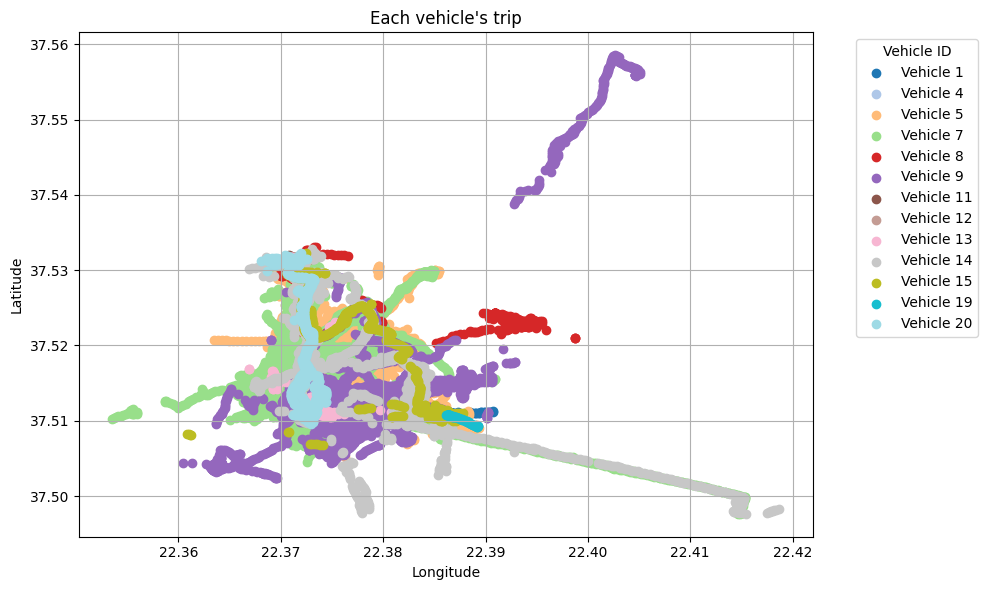

In [ ]:
num_vehicles = len(vehicle_ids)
cmap = plt.cm.get_cmap('tab20', num_vehicles)  

# Plot & save per vehicle
for i, vehicle_id in enumerate(vehicle_ids):
    vehicle_data = vehicles_df[vehicles_df['vehicleId'] == vehicle_id]
    color = cmap(i)

    plt.figure(figsize=(8, 5))
    plt.title(f"Trip for Vehicle {vehicle_id}")
    plt.scatter(vehicle_data['lng'], vehicle_data['lat'], color=color)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.tight_layout()

    filename = f"vehicle_{vehicle_id}_trip.png"
    vehicle_plot_path = os.path.join(SUB_PLOTS_FOLDER_PATH, filename)
    plt.savefig(vehicle_plot_path, bbox_inches='tight')
    print(f"Saved individual plot for vehicle {vehicle_id} to {vehicle_plot_path}")
    plt.close()

# Plot & save all vehicles together
plt.figure(figsize=(10, 6))
plt.title("Each vehicle's trip")

for i, vehicle_id in enumerate(vehicle_ids):
    vehicle_data = vehicles_df[vehicles_df['vehicleId'] == vehicle_id]
    color = cmap(i)
    plt.scatter(vehicle_data['lng'], vehicle_data['lat'], label=f'Vehicle {vehicle_id}', color=color)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save combined plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "all_trips_per_vehicle.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Saved combined plot to {plot_save_path}")

plt.show()

In [ ]:
lat_min, lat_max = 37.00, 37.56
lng_min, lng_max = 22.00, 22.42

inside_coords_df = vehicles_df[
    (vehicles_df['lat'] >= lat_min) & (vehicles_df['lat'] <= lat_max) &
    (vehicles_df['lng'] >= lng_min) & (vehicles_df['lng'] <= lng_max)
]

num_inside = len(inside_coords_df)

print(f"Number of data points within bounds: {num_inside}")


Number of data points within bounds: 47039


## KDE Plot (Smooth Distribution)

### What Does "Density" Stand For?

In **statistics and data visualization**, "density" refers to how frequently data points appear in a given range. Instead of showing counts (like a histogram), **density plots estimate the probability distribution** of the data.

- **Higher density (taller peaks)** means more data points are in that range.
- **Lower density (shorter peaks)** means fewer data points are in that range.

For example:
- A **histogram** shows how many data points fall into specific bins.
- A **KDE plot (Kernel Density Estimate)** smooths the histogram to show a continuous probability distribution.


#### Generate and save a Kernel Density Estimate (KDE) plot for vehicle velocities.

- Flattens the 'velocity' column from the DataFrame into a list.
- Uses Seaborn to create a KDE plot that visualizes the distribution of velocity values.
- Adds labels, title, and grid for clarity.
- Saves the plot as 'velocity_density_kde_plot.png' in the specified plot folder.
- Displays the total number of rows (data points) processed for context.

In [ ]:
# Flatten the velocity data
all_velocities = vehicles_df['velocity'].tolist() 


total_lines = len(vehicles_df)

#### Plot velocities

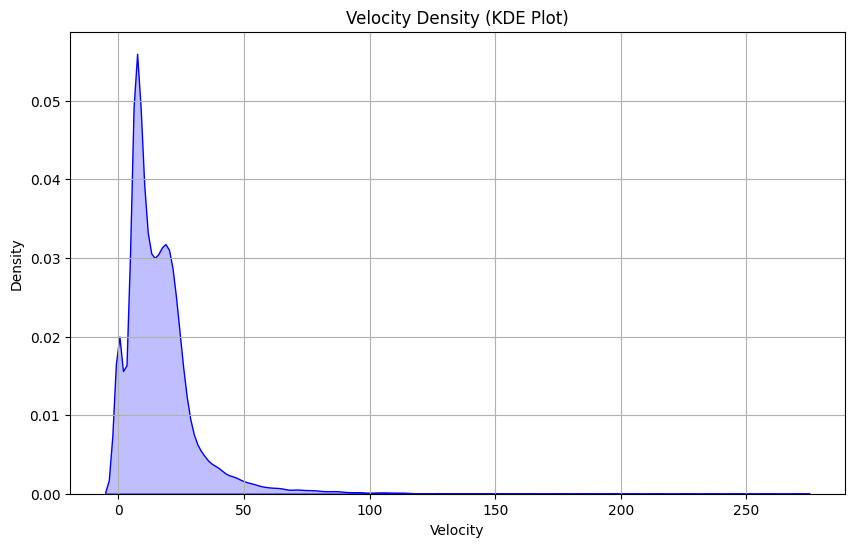

Total rows processed: 47039


In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.title(f'Velocity Density (KDE Plot)')
plt.xlabel('Velocity')

# Plot the KDE (Kernel Density Estimate)
sns.kdeplot(all_velocities, fill=True, color='b')  

plt.grid(True)

# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "velocity_density_kde_plot.png")

# Save the plot
plt.savefig(plot_save_path, bbox_inches='tight')

# Show the plot
plt.show()

# Print the number of rows processed
print(f"Total rows processed: {total_lines}")


#### Compute Peak Velocity value (mode of KDE)

In [ ]:
positive_velocities = [v for v in all_velocities if v >= 0]

kde_func = gaussian_kde(positive_velocities)
x_range = np.linspace(min(positive_velocities), max(positive_velocities), 1000)
kde_values = kde_func(x_range)

peak_index = np.argmax(kde_values)
peak_x = x_range[peak_index]

print(f"Peak velocity value (mode of KDE): {peak_x:.2f}")


Peak velocity value (mode of KDE): 7.30


## Create orientations
- Calculate which the **30 degrees turns** on coordinatess
- Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

### Utility functions for processing coordinates and add bearing and orientation data to the DataFrame.

1. process_coordinates: 
    - Converts the merged DataFrame into a **GeoDataFrame** using latitude and longitude columns.
    - Defines two functions:
        - `calculate_bearing`: Calculates the bearing (direction) between two geographic points.
        - `get_orientation`: Converts a bearing into one of eight cardinal directions (e.g., North, East, etc.).
    - Identifies the latest coordinate and calculates the bearing and orientation between consecutive points.
    - Prints the latest coordinate and the next coordinates with their bearings and orientations.

2. add_bearing_and_orientation_columns: 
    - Calculates the bearing and orientation for each consecutive pair of coordinates in the DataFrame.
    - Adds new columns (`bearing`, `orientation`) to the DataFrame to store the calculated values.
    - The last row in the DataFrame is assigned None for bearing and an empty string for orientation as it has no next point to calculate.

Finally, it processes the data and prints the updated DataFrame with bearing and orientation information.

Returns:
    - *latest_coordinate*: The last coordinate in the DataFrame.
    - *next_coordinates*: A list of tuples containing current and next coordinates along with their bearings and orientations.
    - The *vehicles_df DataFrame with added bearing and orientation columns*.

In [ ]:
def process_coordinates(vehicles_df):
    gvehicles_df = gpd.GeoDataFrame(vehicles_df, geometry=gpd.points_from_xy(vehicles_df['lng'], vehicles_df['lat']))
    
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    def get_latest_and_next_coordinates(gvehicles_df):
        latest_coordinate = gvehicles_df.iloc[-1]  
        next_coordinates = []
        
        for idx in range(len(gvehicles_df) - 1):
            current_row = gvehicles_df.iloc[idx]
            next_row = gvehicles_df.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates
    
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gvehicles_df)

    
    return latest_coordinate, next_coordinates

def add_bearing_and_orientation_columns(vehicles_df):
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    bearings = []
    orientations = []
    
    for idx in range(len(vehicles_df) - 1):
        current_row = vehicles_df.iloc[idx]
        next_row = vehicles_df.iloc[idx + 1]
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        orientation = get_orientation(bearing)
        
        bearings.append(bearing)
        orientations.append(orientation)
    
    bearings.append(None)  # Last row has no next point, so bearing is None
    orientations.append("")  
    
    vehicles_df['bearing'] = bearings
    vehicles_df['orientation'] = orientations
    
    return vehicles_df

latest_coordinate, next_coordinates = process_coordinates(vehicles_df)
vehicles_df = add_bearing_and_orientation_columns(vehicles_df)

print(Fore.YELLOW + "Updated DataFrame:" + Style.RESET_ALL)
print(vehicles_df.head())
print("Finished")

Updated DataFrame:
   vehicleId        lat        lng     dateStored  velocity  odometer  \
0          1  37.510833  22.385710  1717682537000       0.0       0.0   
1          1  37.510603  22.385977  1717682540000       0.0       0.0   
2          1  37.510640  22.385927  1717682545000       6.0       0.0   
3          1  37.510750  22.385907  1717682551000       7.0       0.0   
4          1  37.510877  22.385698  1717682557000      26.0       0.0   

   engineVoltage     dateStoredHuman dateOnlyStoredHuman  timeOnly  \
0           0.28 2024-06-06 17:02:17          2024-06-06  17:02:17   
1           0.28 2024-06-06 17:02:20          2024-06-06  17:02:20   
2           0.28 2024-06-06 17:02:25          2024-06-06  17:02:25   
3           0.28 2024-06-06 17:02:31          2024-06-06  17:02:31   
4           0.28 2024-06-06 17:02:37          2024-06-06  17:02:37   

   seconds_diff  trip_id  distance_m     bearing orientation  
0           0.0        0        0.00  137.402376   Southea

#### Calculate Bearing diff
Calculates the absolute difference between consecutive bearing values within each trip_id.
- Parameters:
    - df (pd.DataFrame): A DataFrame containing 'trip_id' and `bearing` columns.
        
- Returns:
    - pd.DataFrame: DataFrame with a **new column** `bearing_diff`.

In [ ]:
def calculate_bearing_difference(df):
    if 'bearing' not in df.columns or df.empty:
        return df

    def compute_bearing_diff(group):
        group = group.copy()
        group['bearing_diff'] = group['bearing'].diff().abs().fillna(0.0)
        return group

    df = df.groupby('trip_id', group_keys=False).apply(compute_bearing_diff)
    df['bearing_diff'] = df['bearing_diff'].round(2)

    # Fix potential weird index issue from groupby().apply()
    return df.reset_index(drop=True)


vehicles_df = calculate_bearing_difference(vehicles_df)
print(vehicles_df.columns)  # 'bearing_diff' should now exist


Index(['vehicleId', 'lat', 'lng', 'dateStored', 'velocity', 'odometer',
       'engineVoltage', 'dateStoredHuman', 'dateOnlyStoredHuman', 'timeOnly',
       'seconds_diff', 'trip_id', 'distance_m', 'bearing', 'orientation',
       'bearing_diff'],
      dtype='object')


/tmp/ipykernel_9349/948833123.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('trip_id', group_keys=False).apply(compute_bearing_diff)


## Plot **velocities on coordinates**

### Plots a scatter figure of vehicle positions using longitude and latitude, *colored* by velocity. The plot includes grid lines, axis labels, a colorbar, and is saved to the specified plot folder.

- Assumes `vehicles_df` contains 'lng', 'lat', and 'velocity' columns.

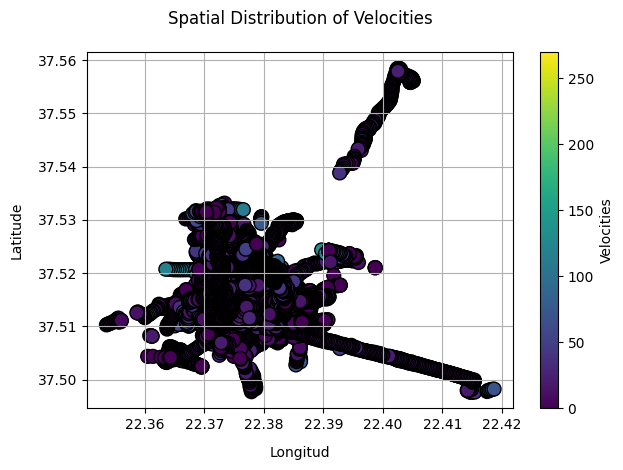

In [ ]:
plt.title('Spatial Distribution of Velocities', pad=20)
plt.xlabel('Longitud', labelpad=10)
plt.ylabel('Latitude', labelpad=10)
plt.grid(True)

# Scatter plot of velocities colored by value
scatter = plt.scatter(
    vehicles_df['lng'], 
    vehicles_df['lat'], 
    c=vehicles_df['velocity'], 
    cmap='viridis', 
    s=100, 
    edgecolors='k'
)

# Add color bar with label
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')

plt.tight_layout()
plt.savefig(f"{PLOT_FOLDER_PATH}velocities_on_coordinates_scatter.png", bbox_inches='tight')

# Show plot
plt.show()

# Data **Cleaning**

## Filter **noise velocties** (>=60)

### Calculates and prints the number and percentage of rows in `vehicles_df` where the 'velocity' exceeds a defined noise threshold (`NOISE_VELOCITIES`). Outputs the total row count, the count of high-velocity rows, and their percentage.

In [ ]:
count_noise_vel = (vehicles_df['velocity'] > NOISE_VELOCITIES).sum()  # Count the rows where 'velocity' >= 65
total_rows = len(vehicles_df)  # Total number of rows in the DataFrame

# Calculate the percentage
percentage = (count_noise_vel / total_rows) * 100

# Print the results
print(f"Total # of lines of DataSet: {total_rows}")
print(f"Num of velocities >= {NOISE_VELOCITIES}: {count_noise_vel}")
print(Fore.YELLOW + f"Percentage of velocities >= {NOISE_VELOCITIES}: {percentage:.2f}%"+ Style.RESET_ALL)

Total # of lines of DataSet: 47039
Num of velocities >= 60: 942
Percentage of velocities >= 60: 2.00%


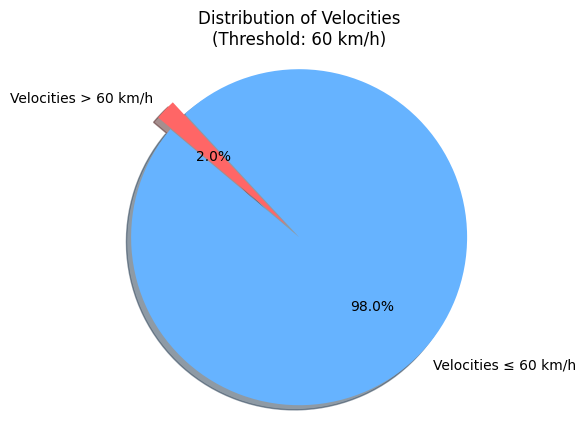

In [ ]:
count_noise_vel = (vehicles_df['velocity'] > NOISE_VELOCITIES).sum()
total_rows = len(vehicles_df)
percentage = (count_noise_vel / total_rows) * 100

labels = ['Velocities ≤ 60 km/h', 'Velocities > 60 km/h']
sizes = [total_rows - count_noise_vel, count_noise_vel]
colors = ['#66b3ff', '#ff6666']
explode = (0, 0.1)


fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')
plt.title(f'Distribution of Velocities\n(Threshold: {NOISE_VELOCITIES} km/h)')

# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Distribution_of_Velocities_scatter_inside_Tripoli's_BOX.png", bbox_inches='tight')

plt.show()


### - **Mark** noise velocities rows
- Create a column that copies the **original noise velocity** of the row

In [ ]:
vehicles_df['noise_velocities'] = (vehicles_df['velocity'] > NOISE_VELOCITIES).astype(int)
percentage_ones = vehicles_df['noise_velocities'].mean() * 100

print(Fore.YELLOW +f"Percentage of 1s in 'noise_velocities': {percentage_ones:.2f}%" + Style.RESET_ALL)


vehicles_df['copy_of_velocity_column'] = np.nan

# Locate rows where the column has value 1
mask = vehicles_df['noise_velocities'] == 1

# Copy the 'velocity' value to 'copy_of_velocity_column'
vehicles_df.loc[mask, 'copy_of_velocity_column'] = vehicles_df.loc[mask, 'velocity']

# Set the 'velocity' to 60 where flag is 1
vehicles_df.loc[mask, 'velocity'] = 60



Percentage of 1s in 'noise_velocities': 2.00%


### Calculate percentage of Tripoli's BBOX data in comparison with all data

#### Get velocity data and vehicle IDs for rows within specified **BBOX**

In [ ]:
def get_velocity_in_area(df, bbox):
    """
    Get velocity data and vehicle IDs for rows within specified latitude and longitude bounds.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        bbox (dict): The bounding box coordinates containing latMin, latMax, lngMin, lngMax.

    Returns:
        pd.DataFrame: A DataFrame containing 'vehicleId' and 'velocity' within the specified area.
    """
    try:
        # Extract bounding box coordinates from the dictionary
        latMin, latMax = bbox['latMin'], bbox['latMax']
        lngMin, lngMax = bbox['lngMin'], bbox['lngMax']
        
        # Filter rows based on latitude and longitude ranges
        filtered_df = df[
            (df['lat'] >= latMin) & (df['lat'] <= latMax) &
            (df['lng'] >= lngMin) & (df['lng'] <= lngMax)
        ]
        
        # Return the subset of DataFrame with 'vehicleId' and 'velocity' columns
        return filtered_df[['vehicleId', 'velocity']]

    except KeyError as e:
        print(f"Error: Missing required column: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])



# Get filtered velocities using the TRIPOLI_BBOX dictionary
BBOX_df = get_velocity_in_area(vehicles_df, TRIPOLI_BBOX)

print(BBOX_df.head())


   vehicleId  velocity
0          1       0.0
1          1       0.0
2          1       6.0
3          1       7.0
4          1      26.0


In [ ]:
vehicles_df.dtypes

vehicleId                           int64
lat                               float64
lng                               float64
dateStored                          int64
velocity                          float64
odometer                          float64
engineVoltage                     float64
dateStoredHuman            datetime64[ns]
dateOnlyStoredHuman                object
timeOnly                           object
seconds_diff                      float64
trip_id                             int64
distance_m                        float64
bearing                           float64
orientation                        object
bearing_diff                      float64
noise_velocities                    int64
copy_of_velocity_column           float64
dtype: object

## Calculate **Acceleration**

### Calculates the velocity difference between consecutive rows and computes the acceleration based on velocity change and time difference. Resets acceleration to 0.0 when there is a change in `vehicleId` or `trip_id`, and handles any NaN values in the `acceleration` column (e.g., due to missing data)

In [ ]:
# Compute velocity difference between consecutive rows
vehicles_df['velocity_diff'] = vehicles_df['velocity'].diff().fillna(0.0)

# Compute acceleration: velocity change / time change
vehicles_df['acceleration'] = (vehicles_df['velocity_diff'] * (1000/3600)) / vehicles_df['seconds_diff']

# Reset acceleration to 0.0 when either vehicleId or trip_id changes
vehicles_df.loc[(vehicles_df['vehicleId'].diff() != 0) | (vehicles_df['trip_id'].diff() != 0), 'acceleration'] = 0.0

# Handle NaN values (e.g., first row, or division by zero)
vehicles_df['acceleration'] = vehicles_df['acceleration'].fillna(0.0)

### Plot Acceleration **stats**

#### Groups `vehicles_df` by `vehicleId` and `trip_id`, calculates the standard deviation and variance of acceleration for each group, and then creates a boxplot visualizing the standard deviation of acceleration per vehicle.

<Figure size 1200x600 with 0 Axes>

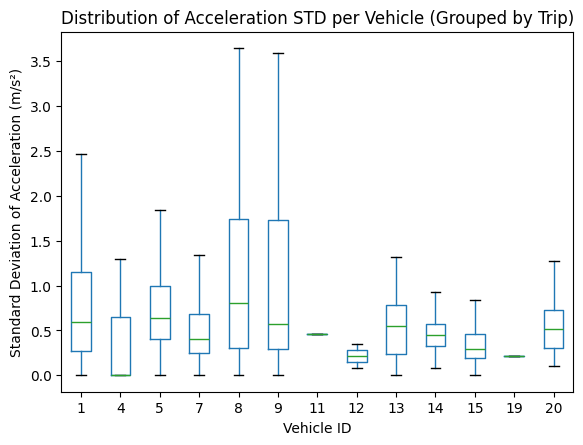

In [ ]:
# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = vehicles_df.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()
# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = vehicles_df.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()


plt.figure(figsize=(12, 6))


accel_stats.boxplot(column='std', by='vehicleId', grid=False, showfliers=False)

plt.title('Distribution of Acceleration STD per Vehicle (Grouped by Trip)')
plt.suptitle('')
plt.xlabel('Vehicle ID')
plt.ylabel('Standard Deviation of Acceleration (m/s²)')


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviationof_Acceleration.png", bbox_inches='tight')
plt.show()

### Avergae Acceleration STD per vehicleId

#### Calculates the mean standard deviation of acceleration per vehicle and creates a bar plot to visualize the average acceleration standard deviation for each vehicle.

In [ ]:
mean_std_per_vehicle = accel_stats.groupby('vehicleId')['std'].mean().reset_index()

#### Plot Barplot Mean Acceleration STD per Vehicle

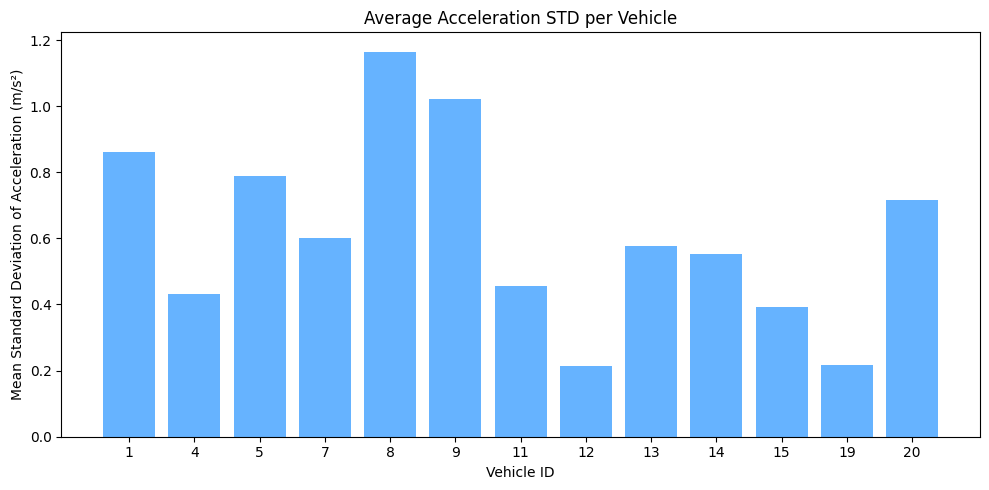

In [ ]:


plt.figure(figsize=(10, 5))
plt.bar(mean_std_per_vehicle['vehicleId'].astype(str), mean_std_per_vehicle['std'], color='#66b3ff')
plt.title('Average Acceleration STD per Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Mean Standard Deviation of Acceleration (m/s²)')
plt.tight_layout()


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Barplot_Mean_Acceleration_STD_per_Vehicle.png")
plt.show()

### Plot Acceleration in comparrison with Velocity

In [ ]:
if 'index' in vehicles_df.columns:
    vehicles_df.drop(columns=['index'], inplace=True)


x = vehicles_df.index.values

# Extract y-values
velocity = vehicles_df['velocity'].values if 'velocity' in vehicles_df.columns else None
acceleration = vehicles_df['acceleration'].values

#### Plot Velocity vs Acceleration

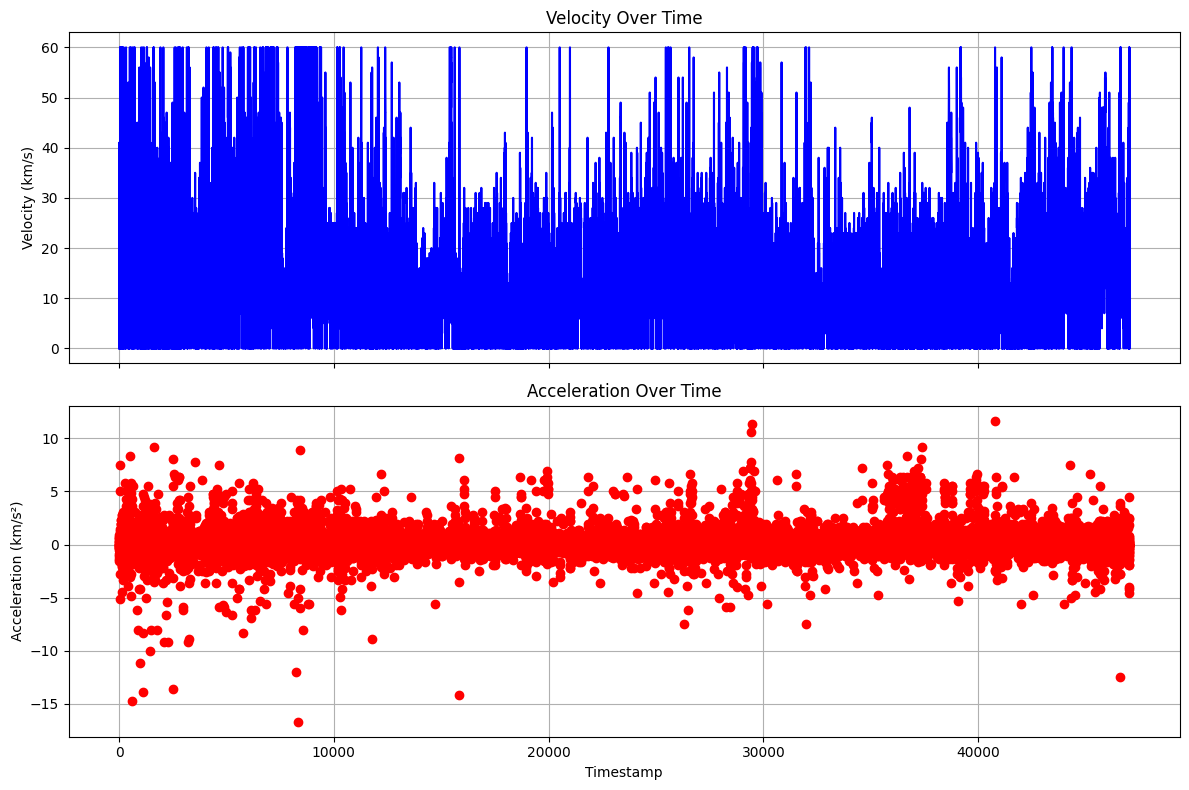

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ---- Plot 1: Velocity ----
if velocity is not None:
    axs[0].plot(x, velocity, color='blue', label='Velocity')
    axs[0].set_ylabel('Velocity (km/s)')
    axs[0].set_title('Velocity Over Time')
    axs[0].grid(True)

# ---- Plot 2: Acceleration ----
axs[1].plot(x, acceleration, marker='o', linestyle='None', color='red', label='Acceleration')
axs[1].set_ylabel('Acceleration (km/s²)')
axs[1].set_title('Acceleration Over Time')
axs[1].set_xlabel('Timestamp')
axs[1].grid(True)

# Layout and save
plt.tight_layout()
plt.savefig(f"{PLOT_FOLDER_PATH}/velocity_and_acceleration_subplots.png", bbox_inches='tight')
plt.show()

## Plot Rate of data logging

### Filters `vehicles_df` for a specific vehicle (`vehicleId = 1`), calculates the time differences between consecutive records, and plots the irregular data logging rate over time.

In [ ]:
df = vehicles_df.copy()

df["timestamp"] = pd.to_datetime(df["dateStoredHuman"])

# Filter data only for vehicleId = 1 (only for example)
df_vehicle = df[df["vehicleId"] == 1]

# Sort data by timestamp
df_vehicle = df_vehicle.sort_values("timestamp").reset_index(drop=True)

# Calculate the time difference between consecutive records
df_vehicle["time_diff"] = df_vehicle["timestamp"].diff().dt.total_seconds()


#### Plot Rate of Data Logging

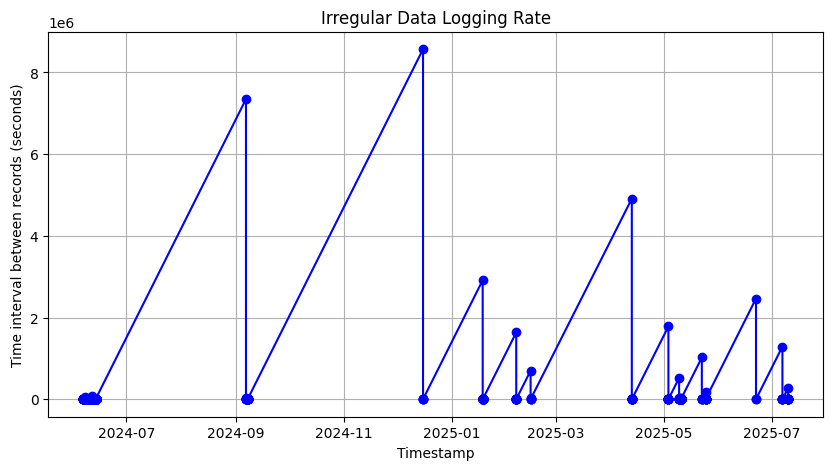

In [ ]:
# Plot time intervals between records
plt.figure(figsize=(10,5))
plt.plot(df_vehicle["timestamp"][1:], df_vehicle["time_diff"][1:], marker='o', linestyle='-', color='b')
plt.xlabel("Timestamp")
plt.ylabel("Time interval between records (seconds)")
plt.title("Irregular Data Logging Rate")
plt.grid()
# Save the filtered plot
plt.savefig(f"{PLOT_FOLDER_PATH}rate_of_data_logging", bbox_inches='tight')
plt.show()


### Filter problematic **accelerations** (< -0.50)

In [ ]:
vehicles_df["isProblem"] = vehicles_df["acceleration"].apply(lambda x: 1 if x < -0.50 else 0) #! isProblem: 1 == False, 0 == True

print(vehicles_df)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  37.510833  22.385710  1717682537000       0.0       0.0   
1              1  37.510603  22.385977  1717682540000       0.0       0.0   
2              1  37.510640  22.385927  1717682545000       6.0       0.0   
3              1  37.510750  22.385907  1717682551000       7.0       0.0   
4              1  37.510877  22.385698  1717682557000      26.0       0.0   
...          ...        ...        ...            ...       ...       ...   
47034         20  37.531627  22.369163  1746694920000      23.0       0.0   
47035         20  37.531603  22.369403  1746694922000       9.0       0.0   
47036         20  37.531575  22.369635  1746694924000       3.0       0.0   
47037         20  37.531545  22.370023  1746694925000       4.0       0.0   
47038         20  37.531525  22.370288  1746694928000       0.0       0.0   

       engineVoltage     dateStoredHuman dateOnlyStoredHuman  timeOnly  ...

# Extract GeoJSONs

## 1) Create GeoJSON from data points with **problematic** acceleration (< -0.50)

In [ ]:
filtered_df = vehicles_df[vehicles_df['acceleration'] < -0.50]

# Build GeoJSON structure
features = []

for _, row in filtered_df.iterrows():
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [row['lng'], row['lat']]
        },
        "properties": {
            "acceleration": row['acceleration']
        }
    }
    features.append(feature)

geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Optionally save to file
with open("../../DataSets/GeoJSON/problematic_acceleration.geojson", "w") as f:
    json.dump(geojson, f, indent=2)

print("GeoJSON created with", len(features), "features.")


GeoJSON created with 3668 features.


## 2) Create GeoJSONs for all vehicles

In [ ]:
def df_to_geojson(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [row['lng'], row['lat']]
            },
            "properties": {
                key: row[key] for key in df.columns if key not in ['lat', 'lng']
            }
        }
        features.append(feature)
    
    return {
        "type": "FeatureCollection",
        "features": features
    }

# Define expected IDs (change this if IDs are not 1–20)
expected_ids = set(range(1, 21))

# Get actual IDs from the DataFrame
actual_ids = set(df['vehicleId'].unique())

# Find missing IDs
missing_ids = list(expected_ids - actual_ids)
print("Missing IDs:", missing_ids)

# Create GeoJSONs for each present ID
geojsons_by_id = {}
for unique_id in actual_ids:
    df_subset = df[df['vehicleId'] == unique_id]
    geojsons_by_id[unique_id] = df_to_geojson(df_subset)




Missing IDs: [2, 3, 6, 10, 16, 17, 18]


# Save DF to **csv**

In [ ]:
all_vehicles_data_path = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
vehicles_df.to_csv(all_vehicles_data_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {all_vehicles_data_path}" + Style.RESET_ALL)

DataFrame stored to ../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv


# **Get data from Overpass API**

In [ ]:
# MongoDB connection
client = MongoClient(DB_URI)  
db = client[DB_COLLECION]  # Replace with your database name
collection = db["Tripoli's_Roads"]  # Replace with your collection name

# Overpass API endpoint
url = "https://overpass-api.de/api/interpreter"

# Extract bounding box coordinates from TRIPOLI_BBOX dictionary
latMin, latMax = TRIPOLI_BBOX['latMin'], TRIPOLI_BBOX['latMax']
lngMin, lngMax = TRIPOLI_BBOX['lngMin'], TRIPOLI_BBOX['lngMax']

# !Check if collection is empty only if DB was updated
if UPDATE_DB and collection.count_documents({}) == 0:
    print(Fore.YELLOW + "Collection is empty. Fetching data from Overpass API..." + Style.RESET_ALL)

    # Overpass QL query to get all types of roads within the bounding box
    query = f"""
    [out:json];
    (
      way({latMin},{lngMin},{latMax},{lngMax})["highway"];
    );
    out geom;
    """

    # Make request to Overpass API
    response = requests.post(url, data=query)

    # Check if the response status is OK (status code 200)
    if response.status_code == 200:
        try:
            # Try to parse the JSON response
            osm_data = response.json()
            elements = osm_data.get("elements", [])

            # Extract relevant data
            named_streets_data = []
            for element in elements:
                tags = element.get("tags", {})
                if 'name' in tags:
                    # Convert string representation of coordinates to list
                    coords_str = element.get("geometry", [])
                    named_streets_data.append([
                        element["id"],
                        "way",
                        tags.get('name', 'Unnamed Street'),
                        tags.get('highway', None),
                        tags.get('name', None),
                        coords_str
                    ])

            # Convert to DataFrame
            df_named_streets = pd.DataFrame(named_streets_data, columns=["id", "type", "name", "highway", "name_en", "coordinates"])

            # Sort the DataFrame by the 'name' column (alphabetically)
            df_named_streets = df_named_streets.sort_values(by='name')

            # Group by the 'name' column and merge coordinates
            df_grouped = df_named_streets.groupby('name').agg({
                'id': 'first',  # Keep the first ID for the road
                'type': 'first',  # Keep the first type (way)
                'highway': 'first',  # Keep the first highway type
                'name_en': 'first',  # Keep the first name_en
                'coordinates': lambda x: sum(x, [])  # Merge all coordinates into one list
            }).reset_index()

            # Convert grouped DataFrame to dictionary and insert it into MongoDB
            collection.insert_many(df_grouped.to_dict('records'))

            print(Fore.GREEN + f"Grouped streets data fetched and saved to MongoDB." + Style.RESET_ALL)

        except ValueError as e:
            # Handle JSON parsing errors
            print(f"Error parsing JSON response: {e}")
    else:
        print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")
        print("Response Text: ", response.text)
else:
    print("Data already exists in the collection. Skipping API request.")



Data already exists in the collection. Skipping API request.
